In [1]:
library(tidyverse)
library(gridExtra)

source("../../evaluation_utils/plots_eda.R")
source("../../evaluation_utils/filtering.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)  
- PRJNA731589 (CHINA)

# Load data

In [2]:
metadata <- read.csv('raw/anno_full_clean.csv', sep = ',') %>%
    filter(is.na(to_exclude)) %>%
    filter(class != "adenoma") %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097", "PRJNA731589"))

cat('Metadata shape:', dim(metadata), '\n')
head(metadata)

Metadata shape: 681 36 


,sample,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,⋯,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude,thomas_alias,cohort_name
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<lgl>,<chr>,<lgl>,⋯,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,SRS9032198,74585900,60354816,80.91987,26094273,34.985531,283,NA,,NA,⋯,0,,,1,62,19.33,healthy,NA,,China5
2,SRS9032196,65367586,53951871,82.53612,10672290,16.326578,291,NA,,NA,⋯,0,,,1,63,30.48,healthy,NA,,China5
3,SRS9032195,66924702,53388902,79.77458,22644575,33.835900,461,NA,,NA,⋯,0,,,1,56,27.93,healthy,NA,,China5
4,SRS9032194,54591836,45123665,82.65643,1900108,3.480572,299,NA,,NA,⋯,0,,,1,59,20.72,healthy,NA,,China5
5,SRS9032193,56774092,44995087,79.25285,5867386,10.334619,398,NA,,NA,⋯,0,,,0,63,20.29,healthy,NA,,China5
6,SRS9032192,62557588,53312559,85.22157,45639070,72.955290,48,NA,,NA,⋯,0,,,0,60,20.96,healthy,NA,,China5


In [3]:
metadata %>% 
    select(study_accession, cohort_name, instrument_model, country, class) %>%
    group_by(study_accession, cohort_name, instrument_model, country, class) %>%
    summarise(n = n()) 

`summarise()` has grouped output by 'study_accession', 'cohort_name',
'instrument_model', 'country'. You can override using the `.groups` argument.


study_accession,cohort_name,instrument_model,country,class,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
PRJEB10878,China1,Illumina HiSeq 2000,CHN,CRC,69
PRJEB10878,China1,Illumina HiSeq 2000,CHN,healthy,53
PRJEB27928,Germany1,Illumina HiSeq 2000,DEU,CRC,15
PRJEB27928,Germany1,Illumina HiSeq 4000,DEU,CRC,6
PRJEB27928,Germany1,Illumina HiSeq 4000,DEU,healthy,58
PRJEB6070,France1,Illumina HiSeq 2000,FRA,CRC,50
PRJEB6070,France1,Illumina HiSeq 2000,FRA,healthy,58
PRJEB6070,Germany2,Illumina HiSeq 2000,DEU,CRC,35
PRJEB6070,Germany2,Illumina HiSeq 2000,DEU,healthy,5


In [4]:
msp_counts <- read.csv("raw/taxa_counts_0.csv", sep = ",")
rownames(msp_counts) <- msp_counts$X
msp_counts <- msp_counts[, -1]
msp_counts <- t(msp_counts)
msp_counts <- msp_counts[, colnames(msp_counts) %in% metadata$sample]

dim(msp_counts)
head(msp_counts)


[1] 2543  681

,SRS9032198,SRS9032196,SRS9032195,SRS9032194,SRS9032193,SRS9032192,SRS9032191,SRS9032190,SRS9032189,SRS9032188,⋯,ERS848627,ERS848626,ERS848625,ERS848624,ERS848623,ERS848622,ERS848621,ERS848620,ERS848619,ERS848618
msp_0001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0002,0,2051,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0003,0,441,259,0,17,0,0,126,571,0,⋯,618,4417,0,0,0,478,1223,10,1207,495
msp_0004,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
msp_0005,91537,60372,28856,1822,4665,374682,2615,20948,158360,1706,⋯,32514,180352,3186,68207,8355,750,3606,2274,676,64027
msp_0006,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Preprocessing

## Filtering

In [5]:
# filter out rows with 0 counts
cat('Before filtering, shape:', dim(msp_counts), '\n')
msp_counts <- msp_counts[rowSums(msp_counts) > 0, ]
cat('After filtering, shape:', dim(msp_counts), '\n')

Before filtering, shape: 2543 681 
After filtering, shape: 2363 681 


In [6]:
# proportion of MSPs with 0 counts
sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))

[1] 0.8764892

In [7]:
# convert zeros to NA
msp_counts[msp_counts == 0] <- NA

# keep only rows that have at least 2 non-NA values per study
msp_counts <- filter_per_center(msp_counts, metadata, 'sample', unique(metadata$cohort_name), 'cohort_name')

# remove columns with only 1 not NA value
msp_counts <- msp_counts[, colSums(!is.na(msp_counts)) > 2]

# update metadata
metadata <- metadata[metadata$sample %in% colnames(msp_counts),]
cat('After filtering, shape:', dim(msp_counts), '\n')

# convert NA back to 0
msp_counts[is.na(msp_counts)] <- 0

Filtering by center - two not-NA per center
	Before filtering: 2363 681 
	After filtering: 755 681 
After filtering, shape: 755 681 


In [8]:
# remove samples where upper quantile is 0 (per dataset)
for (study in unique(metadata$cohort_name)) {
    samples <- metadata$sample[metadata$cohort_name == study]
    study_counts <- msp_counts[, samples]

    quantiles <- apply(study_counts, 2, quantile, probs = 0.75)
    samples_to_remove <- names(quantiles[quantiles == 0])
    
    msp_counts <- msp_counts[, !colnames(msp_counts) %in% samples_to_remove]
}
cat('After filtering, shape:', dim(msp_counts), '\n')

metadata <- metadata[metadata$sample %in% colnames(msp_counts),]

After filtering, shape: 755 526 


In [9]:
dim(metadata)
metadata %>% 
    select(cohort_name, instrument_model, country, class) %>%
    group_by(cohort_name, class) %>%
    summarise(n = n()) 

[1] 526  36

`summarise()` has grouped output by 'cohort_name'. You can override using the
`.groups` argument.


cohort_name,class,n
<chr>,<chr>,<int>
China1,CRC,57
China1,healthy,39
China3,CRC,49
China3,healthy,66
China5,CRC,43
China5,healthy,61
France1,CRC,46
France1,healthy,56
Germany1,CRC,17


In [10]:
sum(msp_counts == 0) / (nrow(msp_counts) * ncol(msp_counts))

[1] 0.6347367

In [11]:
# total_counts <- colSums(msp_counts, na.rm = TRUE)
# msp_counts <- sweep(msp_counts, 2, total_counts, FUN = "/")
# msp_counts <- as.data.frame(msp_counts)

## log transform

In [12]:
logmin_msp_counts <- log2(msp_counts + 1)
dim(logmin_msp_counts)

[1] 755 526

## plots

In [13]:
logmin_msp_counts <- logmin_msp_counts %>% as.data.frame()
metadata <- metadata %>% as.data.frame()

In [14]:
pca_plot_study <- pca_plot(
    logmin_msp_counts, metadata, 
    title = "PCA plot of log2(msp_counts+1)",
    quantitative_col_name = 'sample',
    col_col = "cohort_name", shape_col = "class")
pca_plot_class <- pca_plot(
    logmin_msp_counts, metadata, 
    title = "PCA plot of log2(msp_counts+1)",
    quantitative_col_name = 'sample',
    shape_col = "cohort_name", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_msp_counts, metadata, 
    title = "UMAP plot of log2(msp_counts+1)", color_column = "cohort_name")
umap_plot_class <- umap_plot(
    logmin_msp_counts, metadata, 
    title = "UMAP plot of log2(msp_counts+1)", color_column = "class")

violin_plots <- boxplot_plot_groupped(logmin_msp_counts, metadata,
    title = paste("Violin plot of log2(msp_counts+1)"),
    quantitativeColumnName = "sample",
    color_col = "cohort_name", remove_xnames = T)

boxplot_plots <- boxplot_plot(
    logmin_msp_counts, metadata,
    quantitativeColumnName = 'sample', color_col = "cohort_name",
    title = "Boxplot of of log2(msp_counts+1)")


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


In [15]:
layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
           boxplot_plots /
          violin_plots

options(repr.plot.width=13, repr.plot.height=20)

# save plot
ggsave("plots/filtered_log.png",
    layout, width = 13, height = 20)

## QU norm

In [16]:
# msp_counts[is.na(msp_counts)] <- 0

# cat('Before normalization, shape:', dim(msp_counts), '\n')
# cat('% of zeros:', sum(msp_counts == 0) * 100 / (nrow(msp_counts) * ncol(msp_counts)), '\n')

# quantileExpressed <- apply(msp_counts, 2, function(x) { quantile(x[x > 0], 0.75) })
# msp_counts <- t(t(msp_counts) / quantileExpressed)

# cat('After normalization, shape:', dim(msp_counts_norm), '\n')
# cat('% of zeros:', sum(msp_counts_norm == 0) * 100/ (nrow(msp_counts_norm) * ncol(msp_counts_norm)), '\n')


In [17]:
msp_counts[is.na(msp_counts)] <- 0
msp_counts <- as.data.frame(msp_counts)

# Normalize  inside each study
msp_counts_norm_study <- msp_counts

for (study in unique(metadata$cohort_name)) {
    print(study)
    samples <- metadata$sample[metadata$cohort_name == study]
    print(length(samples))
    study_counts <- msp_counts[, samples]

    quantileExpressed <- apply(study_counts, 2, function(x) { quantile(x[x > 0], 0.75) })
    msp_counts_norm_study[, samples] <- t(t(study_counts) / quantileExpressed)
}
    
msp_counts_norm <- msp_counts_norm_study

cat('After study normalization, shape:', dim(msp_counts_norm_study), '\n')
cat('% of zeros:', sum(msp_counts_norm_study == 0) * 100/ (nrow(msp_counts_norm_study) * ncol(msp_counts_norm_study)), '\n')


[1] "China5"
[1] 104
[1] "China3"
[1] 115
[1] "Germany2"
[1] 38
[1] "France1"
[1] 102
[1] "Germany1"
[1] 71
[1] "China1"
[1] 96
After study normalization, shape: 755 526 
% of zeros: 63.47367 


In [18]:
msp_counts_norm <- msp_counts_norm %>% as.data.frame()
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0],na.rm = T)/2)

pca_plot_study <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    col_col = "cohort_name", shape_col = "class")

pca_plot_class <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(msp_counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    shape_col = "cohort_name", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(msp_counts+0.5min) UQ norm", color_column = "cohort_name")
umap_plot_class <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(msp_counts+0.5min) UQ norm", color_column = "class")

boxplot_results <- boxplot_plot(
    logmin_msp_counts_norm, metadata,
    quantitativeColumnName = 'sample', color_col = "cohort_name",
    title = "Boxplot of merged MSPs, log2(msp_counts), UQ norm")

violin_plots <- boxplot_plot_groupped(logmin_msp_counts_norm, metadata,
    title = paste("Violin plot of log2(msp_counts+0.5min), UQ norm"),
    quantitativeColumnName = "sample",
    color_col = "cohort_name", remove_xnames = T)

density_plot <- plotIntensityDensity(
    logmin_msp_counts_norm, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'cohort_name',
    title = "Density plot of log2(msp_counts+0.5min), UQ norm")

layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          violin_plots /
            density_plot

options(repr.plot.width=13, repr.plot.height=23)



No id variables; using all as measure variables



In [19]:
ggsave("plots/filtered_logmin_uq_norm.png",
    layout, width = 13, height = 23)

# Save preprocessed data

In [20]:
# return 0 
msp_counts_norm[is.na(msp_counts_norm)] <- 0
msp_counts[is.na(msp_counts)] <- 0
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0])/2)

rownames(metadata) <- metadata$sample

for(center in unique(metadata$cohort_name)){
    # select only samples from the center
    center_msp_counts <- msp_counts[, metadata[metadata$cohort_name == center,]$sample]
    center_msp_counts_norm <- msp_counts_norm[, metadata[metadata$cohort_name == center,]$sample]
    center_logmin_msp_counts_norm <- logmin_msp_counts_norm[, metadata[metadata$cohort_name == center,]$sample]
    metadata_center <- metadata[metadata[metadata$cohort_name == center,]$sample, ]

    # save then to the corresponding folder
    path_center <- paste0('before/', center, '/')
    #check if the folder exists and create it if not
    if (!dir.exists(path_center)){
        # create the folder
        print(paste('Creating folder:', path_center))
        dir.create(path_center)
    }

    path_before <- paste0('before/', center, '/intermediate/')
    #check if the folder exists and create it if not
    if (!dir.exists(path_before)){
        # create the folder
        print(paste('Creating folder:', path_before))
        dir.create(path_before)
    }
    write.table(rownames_to_column(center_msp_counts, 'MSP'), paste0(path_before, 'msp_counts_raw_5C.tsv'), sep = '\t', row.names = F)
    write.table(rownames_to_column(center_msp_counts_norm, 'MSP'), paste0(path_before, 'msp_counts_norm_5C.tsv'), sep = '\t', row.names = F)
    write.table(rownames_to_column(center_logmin_msp_counts_norm, 'MSP'), paste0(path_before, 'msp_counts_norm_logmin_5C.tsv'), sep = '\t', row.names = F)
    write.table(metadata_center, paste0(path_before, 'metadata_5C.tsv'), sep = '\t', row.names = F)
}

# save for the central analysis
write.table(msp_counts_norm %>% rownames_to_column('MSP'), 
    file = "before/normalized_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)
write.table(msp_counts %>% rownames_to_column('MSP'), 
    file = "before/raw_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)
write.table(logmin_msp_counts_norm %>% rownames_to_column('MSP'),
    file = "before/logmin_normalized_counts_5C.tsv", sep = "\t", quote = FALSE, row.names = F)

# save metadata
write.table(metadata, file = "before/metadata_5C.tsv", sep = "\t", quote = FALSE)

In [21]:
dim(logmin_msp_counts_norm)

[1] 755 526

# Batch effects correction

In [22]:
# arrane normalized data 
msp_counts_norm <- msp_counts_norm %>% as.data.frame()
msp_counts_norm <- msp_counts_norm[,metadata$sample]

In [23]:
metadata <- metadata %>%
    mutate(class = factor(class, levels = c("healthy", "CRC")))

In [24]:
# create design
design = model.matrix(~class, data = metadata)
colnames(design) <- c("Intercept", "CRC")
rownames(design) <- metadata$sample

# log2
logmin_msp_counts_norm <- log2(msp_counts_norm + min(msp_counts_norm[msp_counts_norm > 0],na.rm = T)/2)
msp_norm_corrected <- limma::removeBatchEffect(logmin_msp_counts_norm, metadata$cohort_name, design = design) %>% as.data.frame()


No id variables; using all as measure variables



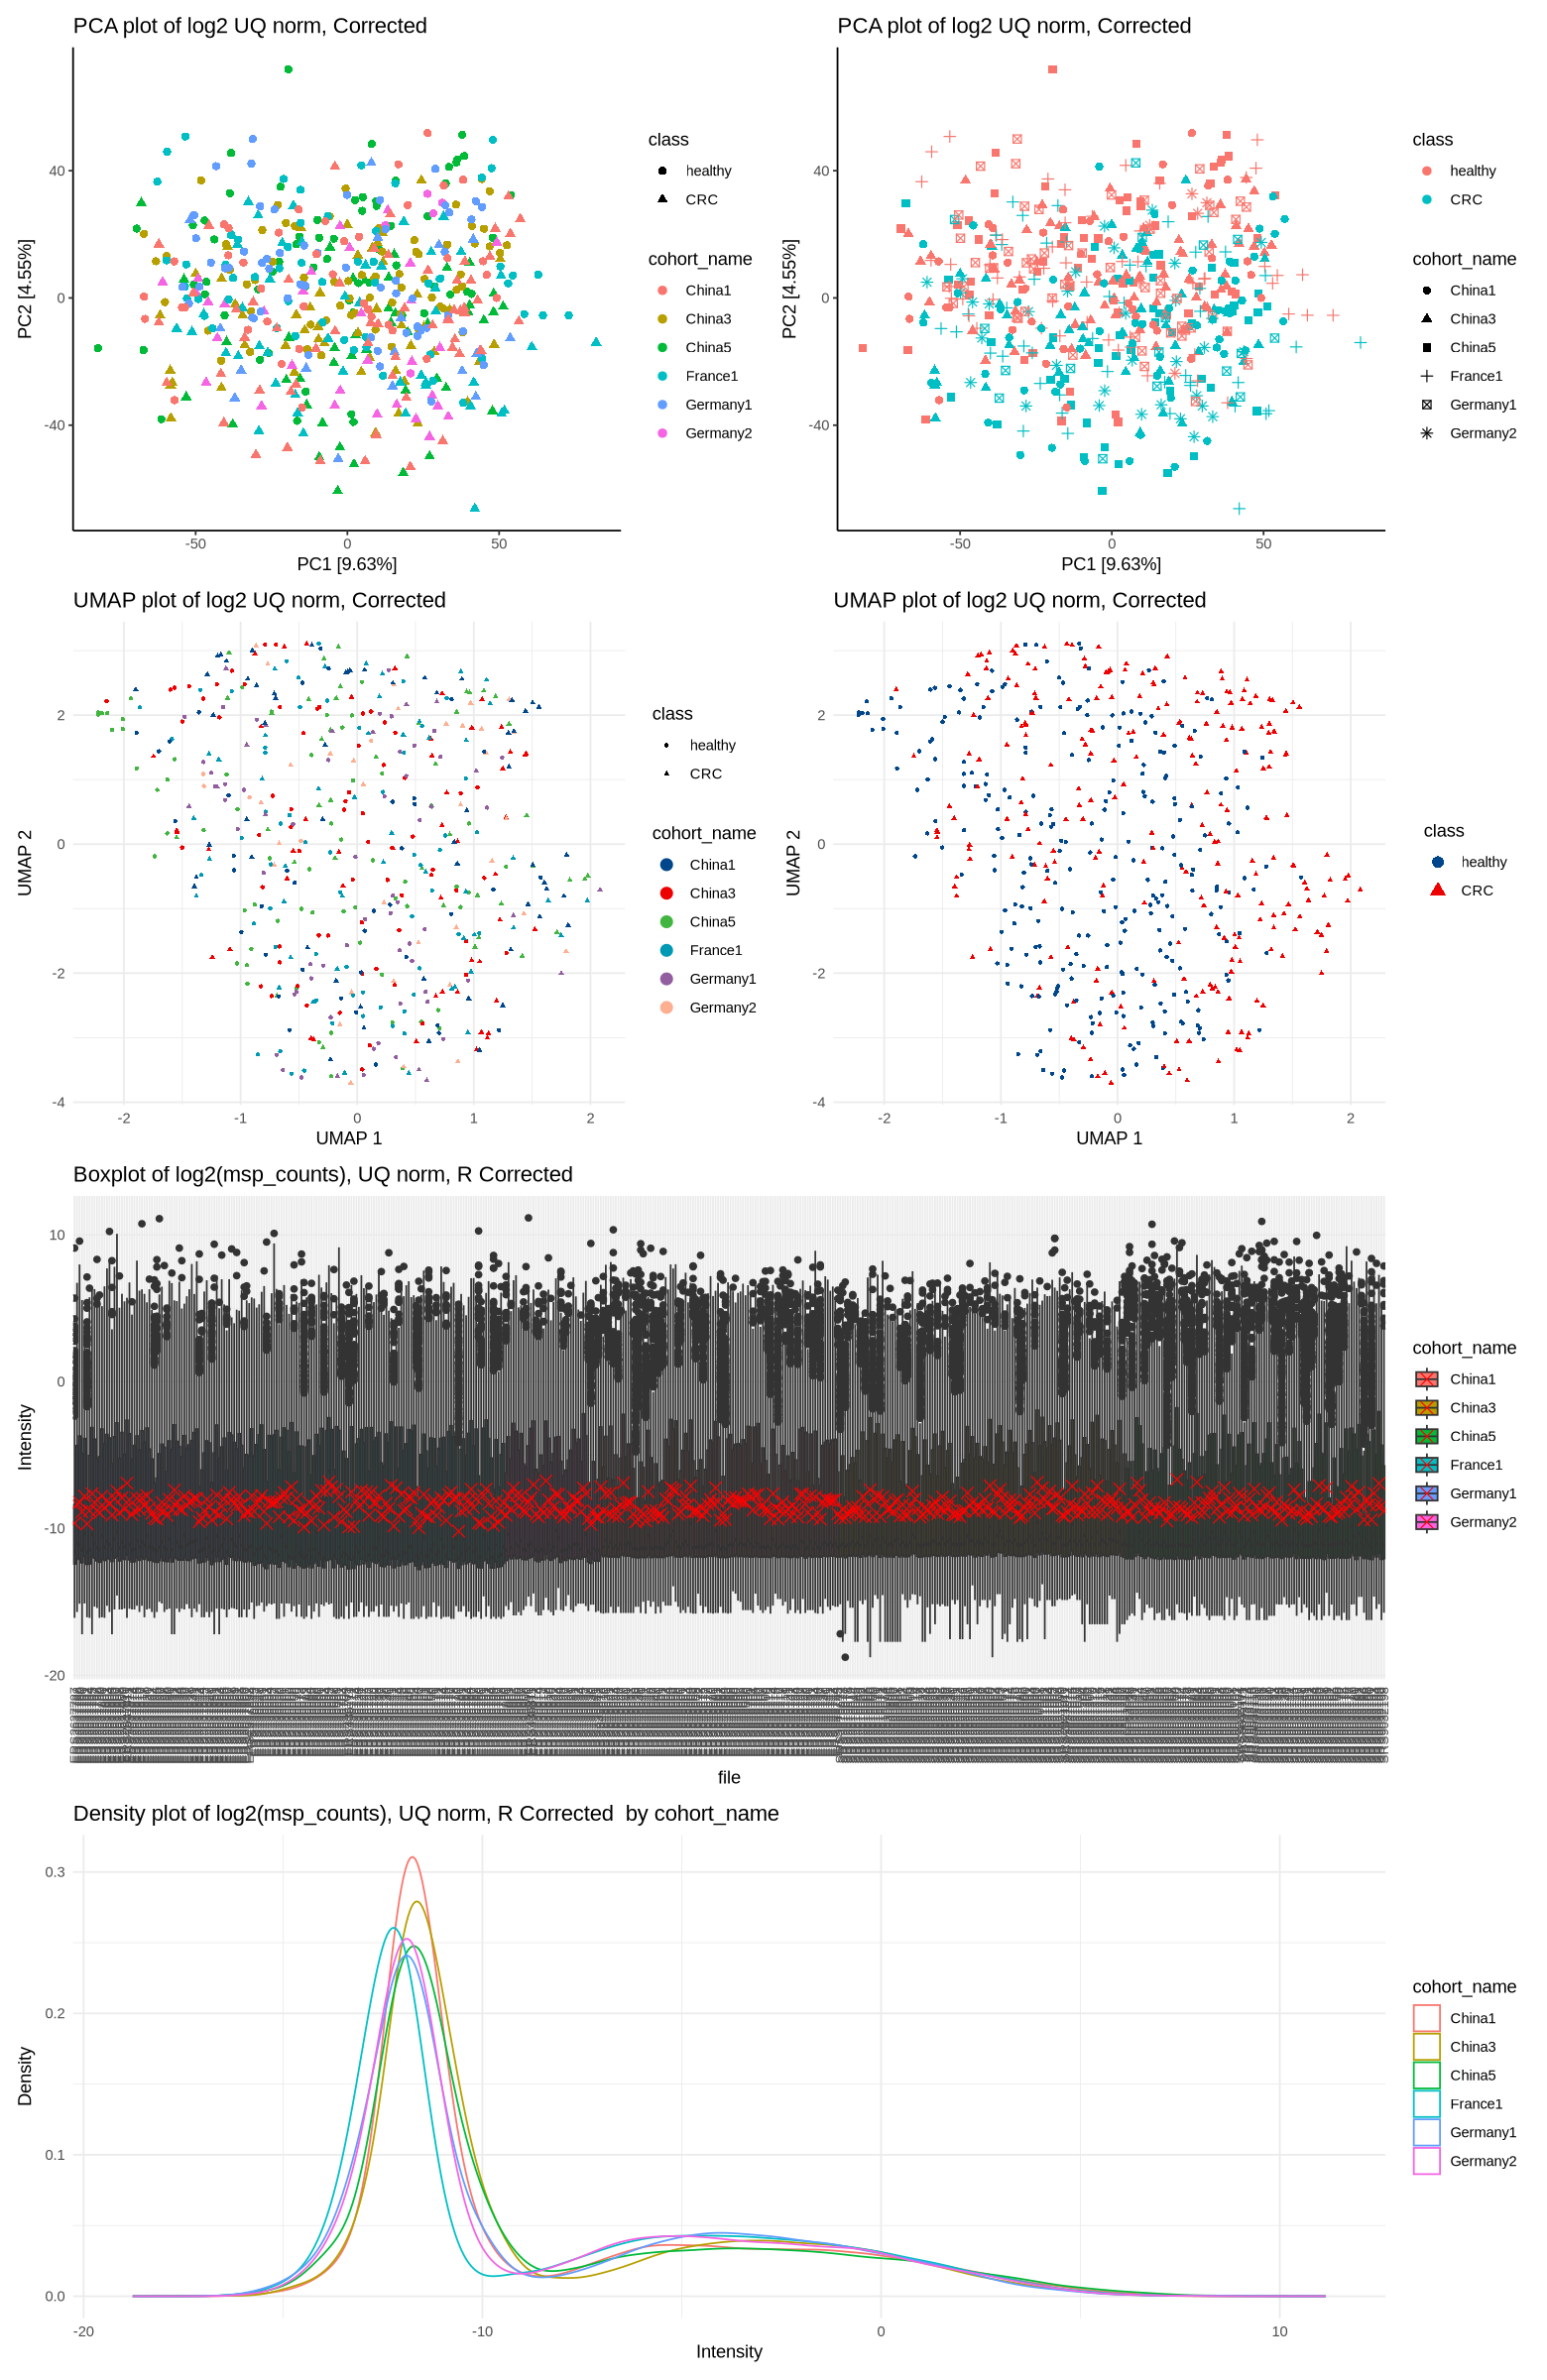

In [25]:
pca_plot_study <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm, Corrected",
    quantitative_col_name = 'sample',
    col_col = "cohort_name", shape_col = "class")

pca_plot_class <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm, Corrected",
    quantitative_col_name = 'sample',
    shape_col = "cohort_name", col_col = "class")

umap_plot_study <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm, Corrected", color_column = "cohort_name")
umap_plot_class <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm, Corrected", color_column = "class")


boxplot_results <- boxplot_plot(
    msp_norm_corrected, metadata,
    quantitativeColumnName = 'sample', color_col = "cohort_name",
    title = "Boxplot of log2(msp_counts), UQ norm, R Corrected")

density_plot <- plotIntensityDensity(
    msp_norm_corrected, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'cohort_name',
    title = "Density plot of log2(msp_counts), UQ norm, R Corrected")


layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=20)
layout


In [26]:
# save 
ggsave("plots/filtered_logmin_uq_norm_Rcorrected.png",
    layout, width = 13, height = 23)

In [27]:
msp_norm_corrected[is.na(msp_norm_corrected)] <- 0
design <- design %>% as.data.frame()

for(center in unique(metadata$cohort_name)){
    design_center <- design[metadata[metadata$cohort_name == center,]$sample, ]["CRC"]
    # save then to the corresponding folder
    path_after <- paste0('after/', center, '/')
    path_before <- paste0('before/', center, '/')
    #check if the folder exists and create it if not
    write.table(rownames_to_column(design_center, 'sample'), 
                paste0(path_before, 'design_5C.tsv'), sep = '\t', row.names = F)

    # study logmin_msp_counts_norm
    counts_for_correction <- logmin_msp_counts_norm[, rownames(design_center)]
    write.table(rownames_to_column(counts_for_correction, "gene_ID"),
                paste0(path_before, 'UQnorm_log_counts_for_corr.tsv'), sep = '\t', row.names = F)
}

# save for the central analysis
write.table(msp_norm_corrected %>% rownames_to_column('MSP'), 
    file = "after/normalized_logmin_counts_5centers_Rcorrected.tsv", sep = "\t", quote = FALSE, row.names = F)

# Session info

In [28]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/yuliya/miniforge3/envs/fedRBE/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] data.table_1.15.4 viridis_0.6.5     viridisLite_0.4.2 ggsci_3.2.0      
 [5] umap_0.2.10.0     patchwork_1.3.0   gridExtra_2.3     lubridate_1.9.3  
 [9] forcats_1.0.0     stringr_1.5.1     dplyr_1.1.4    